# 1. Loading the data and basic preprocessing

##### Data: Financial indicators of Taiwan companies (source: Taiwan Economic Journal 1999–2009)

##### Task: Bankruptcy prediction

https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

In [165]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter
from itertools import permutations, product, combinations
from functools import reduce

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import os
import re
import csv
from tqdm import tqdm
import multiprocessing as mp

from utils import str_to_readable_title, filter_dataset, pd_to_cubes

In [166]:
MODELS_PATH = 'models'
METRIC_DF_COLS = ['Weighted accuracy', 'Precision class 0', 'Precision class 1', 
                  'Recall class 0', 'Recall class 1', 'F1 class 0', 'F1 class 1','F-Beta']

hyperparameter_list = []

In [167]:
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)

In [168]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [169]:
matplotlib.rcParams.update({'font.size': 16})

## 1.1. Read data

In [274]:
df = pd.read_csv("data.csv")

In [275]:
df

Bankrupt?   ROA(C) before interest and depreciation before interest   
0             1                                           0.370594         \
1             1                                           0.464291          
2             1                                           0.426071          
3             1                                           0.399844          
4             1                                           0.465022          
...         ...                                                ...          
6814          0                                           0.493687          
6815          0                                           0.475162          
6816          0                                           0.472725          
6817          0                                           0.506264          
6818          0                                           0.493053          

       ROA(A) before interest and % after tax   
0                                    0.424389  \
1                                    0.538214   
2                                    0.499019   
3                                    0.451265   
4                                    0.538432   
...                                       ...   
6814                                 0.539468   
6815                                 0.538269   
6816                                 0.533744   
6817                                 0.559911   
6818                                 0.570105   

       ROA(B) before interest and depreciation after tax   
0                                              0.405750   \
1                                              0.516730    
2                                              0.472295    
3                                              0.457733    
4                                              0.522298    
...                                                 ...    
6814                                           0.543230    
6815                                           0.524172    
6816                                           0.520638    
6817                                           0.554045    
6818                                           0.549548    

       Operating Gross Margin   Realized Sales Gross Margin   
0                    0.601457                      0.601457  \
1                    0.610235                      0.610235   
2                    0.601450                      0.601364   
3                    0.583541                      0.583541   
4                    0.598783                      0.598783   
...                       ...                           ...   
6814                 0.604455                      0.604462   
6815                 0.598308                      0.598308   
6816                 0.610444                      0.610213   
6817                 0.607850                      0.607850   
6818                 0.627409                      0.627409   

       Operating Profit Rate   Pre-tax net Interest Rate   
0                   0.998969                    0.796887  \
1                   0.998946                    0.797380   
2                   0.998857                    0.796403   
3                   0.998700                    0.796967   
4                   0.998973                    0.797366   
...                      ...                         ...   
6814                0.998992                    0.797409   
6815                0.998992                    0.797414   
6816                0.998984                    0.797401   
6817                0.999074                    0.797500   
6818                0.998080                    0.801987   

       After-tax net Interest Rate   
0                         0.808809  \
1                         0.809301   
2                         0.808388   
3                         0.808966   
4                         0.809304   
...                            ...   
6814                      0

Column names

In [276]:
list(df)[:10]

['Bankrupt?',
 ' ROA(C) before interest and depreciation before interest',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' Operating Gross Margin',
 ' Realized Sales Gross Margin',
 ' Operating Profit Rate',
 ' Pre-tax net Interest Rate',
 ' After-tax net Interest Rate',
 ' Non-industry income and expenditure/revenue']

##### Basic normalization of column names:
* remove blank chars at the begining/end of string
* remove possible double spaces
* lowercase

In [277]:
normalize_names = lambda x: re.sub("[\?\s]+", " ", x).strip().lower()

In [278]:
df.rename(columns=normalize_names, inplace=True)

In [279]:
col_names = list(df)

In [280]:
col_names[:10]

['bankrupt',
 'roa(c) before interest and depreciation before interest',
 'roa(a) before interest and % after tax',
 'roa(b) before interest and depreciation after tax',
 'operating gross margin',
 'realized sales gross margin',
 'operating profit rate',
 'pre-tax net interest rate',
 'after-tax net interest rate',
 'non-industry income and expenditure/revenue']

##### Adjust data types

In [319]:
# df.dtypes

In [282]:
df.__sizeof__()

5237120

In [283]:
df[df.dtypes[df.dtypes == np.float64].index] = df[df.dtypes[df.dtypes == np.float64].index].astype(np.float32)
df[df.dtypes[df.dtypes == np.int64].index] = df[df.dtypes[df.dtypes == np.int64].index].astype(np.uint8)

In [284]:
df.__sizeof__()

2557253

In [285]:
def add_value_label(x_list,y_list):
    for i in range(len(x_list)):
        plt.text(i, y_list[i], '{0:.2%}'.format(y_list[i]), size=16)

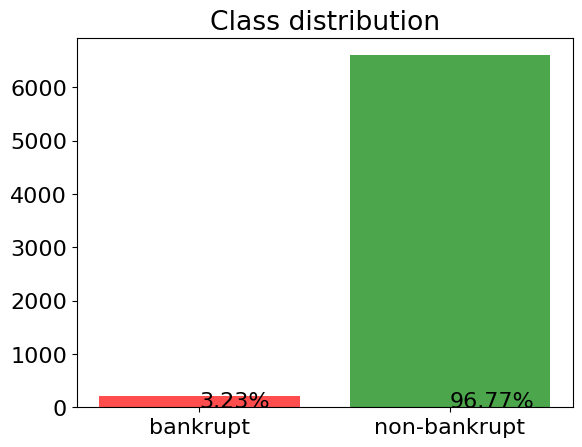

In [287]:
matplotlib.rcParams.update({'font.size': 16})

num_yes = len(df[df['bankrupt'] == 1])
num_no = len(df[df['bankrupt'] == 0])

plt.bar(['bankrupt', 'non-bankrupt'], [num_yes, num_no], color=['red', 'green'], alpha=0.7)
plt.title("Class distribution")
add_value_label(['bankrupt', 'non-bankrupt'], 
                [round(num_yes / (num_no + num_yes), 4), round(num_no / (num_no + num_yes), 4)])

## 1.2. Data cleaning and preprocessing

Before feeding ML algorithms the data should be normalized. Values from different features have to be roghly from the same range to ensure that features with higher values are not effecting algorithms in higher extent.

But we know that most of the columns (if not all of them) represent financial idnicators, that are supposed to be in range (0, 1), thereby don't need to be normalized.

So let's check it out. We make histograms for each column to see if all of them actualy have values in range (0, 1).

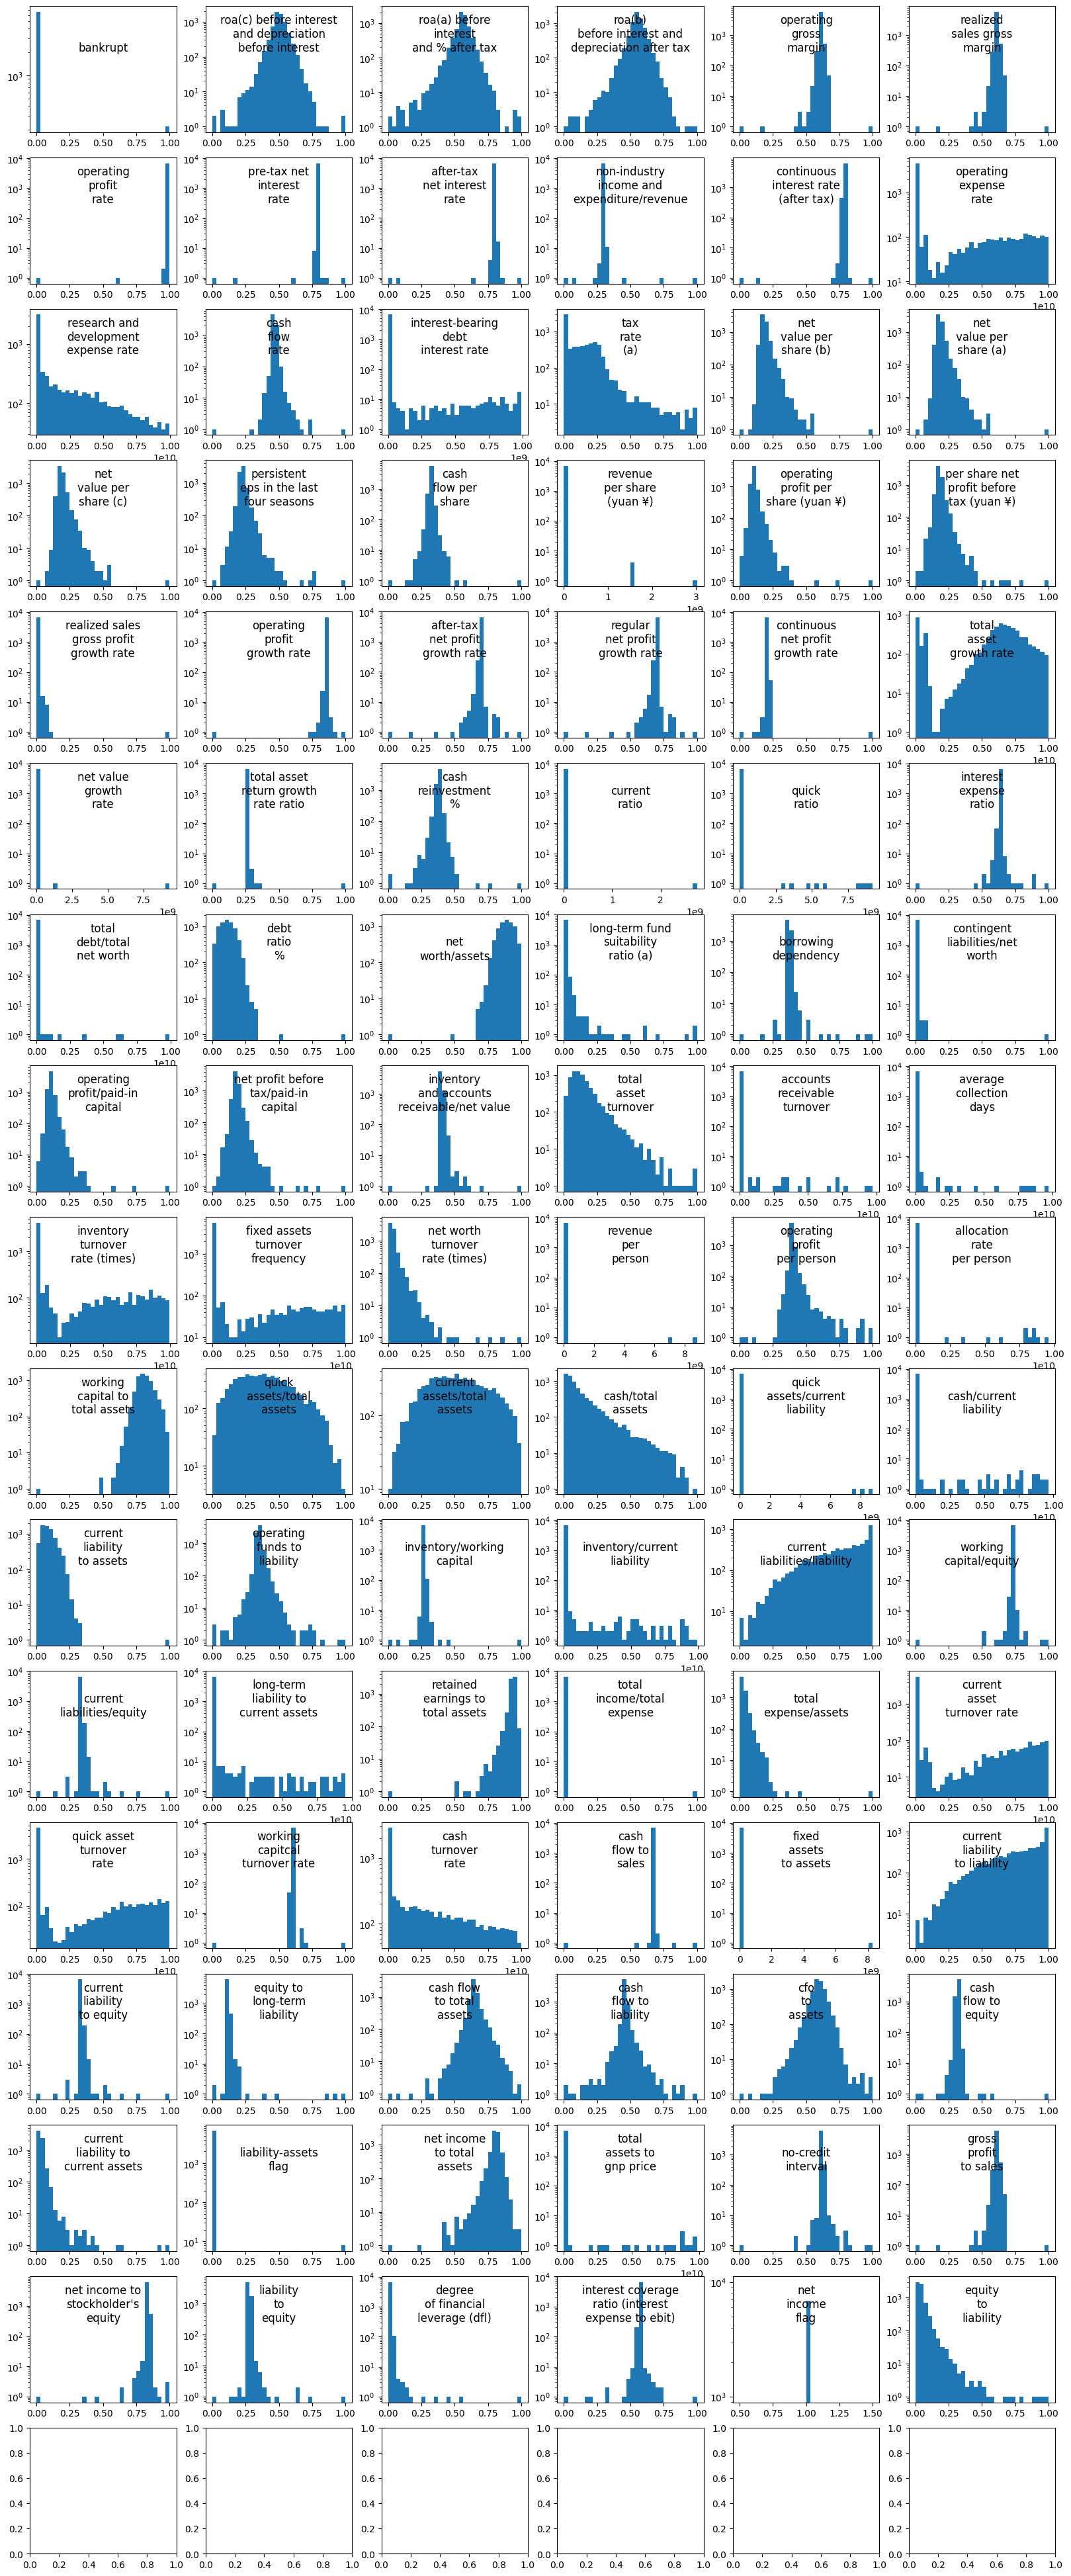

In [288]:
matplotlib.rcParams.update({'font.size': 10})

n_cols = len(df.columns)
c, r = 6, len(df.columns) // 6 + 1
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(20, 50))

for i in range(n_cols):
    title = str_to_readable_title(df.columns[i], max_lines=3)
    row_id, col_id = i // 6, i % 6
    ax[row_id, col_id].hist(df.iloc[:, i], log=True, bins=32)
    ax[row_id, col_id].set_title(title, x=0.5, y=0.6)
    

plt.show()
# fig.savefig(os.path.join('images', 'feature_histograms.png'))

We can see that some columns (`Operating Expense Rate`, `Research and development expense rate`, ...) have significant number (let's say >100) of values above 1 and up to 10e10. There are also columns (`Revenue per Share`, `Current Ratio`, ...) with insignificant (let's say <100) number of values from a mentioned range. The reason for occasionally high values is that they probably represent just a one of the elements of a given financial indicator. 

This fact makes such observations/features irrelevant for ML algorithms as the same feature gives different type of knowledge for different observations. To give an example, Operating Expense Rate (OER) = Operating Expenses / Net Sales. Significant part of observations have OER in range (0, 1) actually representing ratios, - the second part has OER > 1 probably representing just an Operating Expenses.

This brings us to the "data cleaning" step as we need to remove either rows or columns containing irrelevant values. But which dataset's dimension (rows or columns) do we have to chose to clean along? Well, for a performance of ML models both the number of observations and the number of features are important in terms of amount of information they give. Thereby while removing, we want to keep as many of them as possible. 

My proposition for handling this issue is to:
* remove columns with significant number of irrelevant values and
* remove rows where at least one of the feature has insignificant number of irrelevant values.

But how do we determine what is that threshold, which tells if column has significant or insignificant number of irrelevant values? Well, this is a parameter, for which we need to figure out an optimal value. We can do that by testing different thresholds and finding the one that keeps the most data from original dataset (this can be simply measured as `NUMBER_OF_ROWS_LEFT * NUMBER_OF_COLUMNS_LEFT`). Another important thing to keep in mind is that our data is highly imbalanced (~3.3% bankrupts, 96.7% non-bankrupts), and we can't remove a lot of bankrupt instances. 

---

In [289]:
matplotlib.rcParams.update({'font.size': 16})

##### Remove flag (binary) columns from filtering (excl. `bankrupt` column)

In [290]:
df_X = df.copy()
df_X = df_X.drop(columns=list(df.columns[df.isin([1,0]).all()]))
df_X['bankrupt'] = df['bankrupt']

In [291]:
df_X.head()

roa(c) before interest and depreciation before interest   
0                                           0.370594        \
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   roa(a) before interest and % after tax   
0                                0.424389  \
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   roa(b) before interest and depreciation after tax  operating gross margin   
0                                           0.405750                0.601457  \
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                           0.457733                0.583541   
4                                           0.522298                0.598783   

   realized sales gross margin  operating profit rate   
0                     0.601457               0.998969  \
1                     0.610235               0.998946   
2                     0.601364               0.998857   
3                     0.583541               0.998700   
4                     0.598783               0.998973   

   pre-tax net interest rate  after-tax net interest rate   
0                   0.796887                     0.808809  \
1                   0.797380                     0.809301   
2                   0.796403                     0.808388   
3                   0.796967                     0.808966   
4                   0.797366                     0.809304   

   non-industry income and expenditure/revenue   
0                                     0.302646  \
1                                     0.303556   
2                                     0.302035   
3                                     0.303350   
4                                     0.303475   

   continuous interest rate (after tax)  operating expense rate   
0                              0.780985            1.256969e-04  \
1                              0.781506            2.897851e-04   
2                              0.780284            2.361297e-04   
3                              0.781241            1.078888e-04   
4                              0.781550            7.890000e+09   

   research and development expense rate  cash flow rate   
0                                    0.0        0.458143  \
1                                    0.0        0.461867   
2                             25500000.0        0.458521   
3                                    0.0        0.465705   
4                                    0.0        0.462746   

   interest-bearing debt interest rate  tax rate (a)  net value per share (b)   
0                             0.000725           0.0                 0.147950  \
1                             0.000647           0.0                 0.182251   
2                             0.000790           0.0                 0.177911   
3                             0.000449           0.0                 0.154187   
4                             0.000686           0.0                 0.167502   

   net value per share (a)  net value per share (c)   
0                 0.147950                 0.147950  \
1                 0.182251                 0.182251   
2                 0.177911                 0.193713   
3                 0.154187                 0.154187   
4                 0.167502                 0.167502   

   persistent eps in the last four seasons  cash flow per share   
0                                 0.169141             0.311664  \
1                                 0.208944             0.318137   
2                                 0.180581             0.307102   
3                

In [293]:
arr_t = np.arange(df_X.shape[0], step=5)  # possible thresholds
arr_t[0] = 1
df_tresholds = pd.DataFrame(data={'thresholds': arr_t,
                                 'data_keep_ratio': np.zeros(arr_t.shape[0]),
                                 'bankruptcy_ratio': np.zeros(arr_t.shape[0])
                                 }
                           )

ints = df_tresholds.dtypes[df_tresholds.dtypes == int].index
floats = df_tresholds.dtypes[df_tresholds.dtypes == float].index
df_tresholds[ints] = df_tresholds[ints].astype(np.uint16)
df_tresholds[floats] = df_tresholds[floats].astype(np.float32)
df_tresholds

thresholds  data_keep_ratio  bankruptcy_ratio
0              1              0.0               0.0
1              5              0.0               0.0
2             10              0.0               0.0
3             15              0.0               0.0
4             20              0.0               0.0
...          ...              ...               ...
1359        6795              0.0               0.0
1360        6800              0.0               0.0
1361        6805              0.0               0.0
1362        6810              0.0               0.0
1363        6815              0.0               0.0

[1364 rows x 3 columns]

In [294]:
def filter_dataset_and_calculate_info_drop(row):
    data_keep_ratio, bankrupt_ratio = filter_dataset(df_X, label_col='bankrupt', t=row[0], return_df=False)
    return pd.Series([row[0], data_keep_ratio, bankrupt_ratio],
                    index=['thresholds', 'data_keep_ratio', 'bankruptcy_ratio']
                    ).astype(np.float16)

In [295]:
df_tresholds = df_tresholds.apply(filter_dataset_and_calculate_info_drop, axis=1)
df_tresholds

thresholds  data_keep_ratio  bankruptcy_ratio
0            1.0         0.744629          0.032257
1            5.0         0.796875          0.031860
2           10.0         0.826172          0.031647
3           15.0         0.835449          0.031708
4           20.0         0.844238          0.031799
...          ...              ...               ...
1359      6796.0         0.008507          0.000000
1360      6800.0         0.008507          0.000000
1361      6804.0         0.008507          0.000000
1362      6808.0         0.008507          0.000000
1363      6816.0         0.008507          0.000000

[1364 rows x 3 columns]

In [296]:
df_tresholds[df_tresholds.data_keep_ratio == df_tresholds.data_keep_ratio.max()]

thresholds  data_keep_ratio  bankruptcy_ratio
10        50.0         0.866211          0.029602
11        55.0         0.866211          0.029602
12        60.0         0.866211          0.029602
13        65.0         0.866211          0.029602
14        70.0         0.866211          0.029602
15        75.0         0.866211          0.029602
16        80.0         0.866211          0.029602
17        85.0         0.866211          0.029602
18        90.0         0.866211          0.029602
19        95.0         0.866211          0.029602

In [297]:
opt_thresholds = df_tresholds.thresholds[df_tresholds.data_keep_ratio == df_tresholds.data_keep_ratio.max()].values
opt_thresholds

array([50., 55., 60., 65., 70., 75., 80., 85., 90., 95.], dtype=float16)

Text(0, 0.5, 'Bankruptcy ratio')

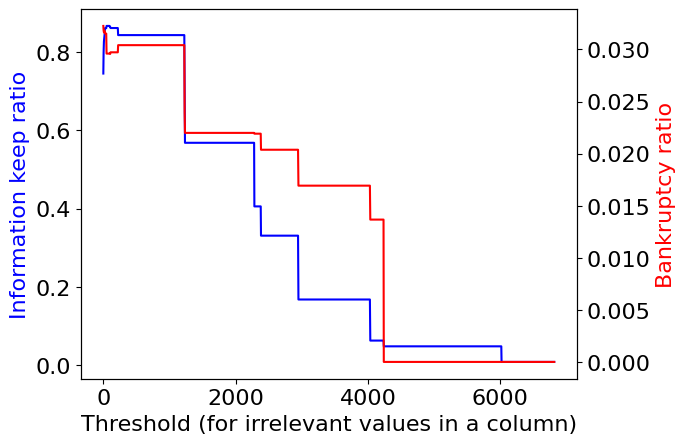

In [298]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_tresholds.thresholds, df_tresholds.data_keep_ratio, color='blue')
ax2.plot(df_tresholds.thresholds, df_tresholds.bankruptcy_ratio, color='red')

# plt.axvline(x=opt_thresh, color='green', linestyle='dashed')
# plt.legend(loc='upper left')
ax1.set_xlabel('Threshold (for irrelevant values in a column)')
ax1.set_ylabel('Information keep ratio', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')
# ax2.set_ylim((2e-2, 4e-2))
# plt.title('Threshold and information lost')

##### Zoom in

In [299]:
rng = (0, 500)
df_tresholds_zoomed = df_tresholds[(df_tresholds.thresholds >= rng[0]) & (df_tresholds.thresholds <= rng[1])]

Text(0, 0.5, 'Bankruptcy ratio')

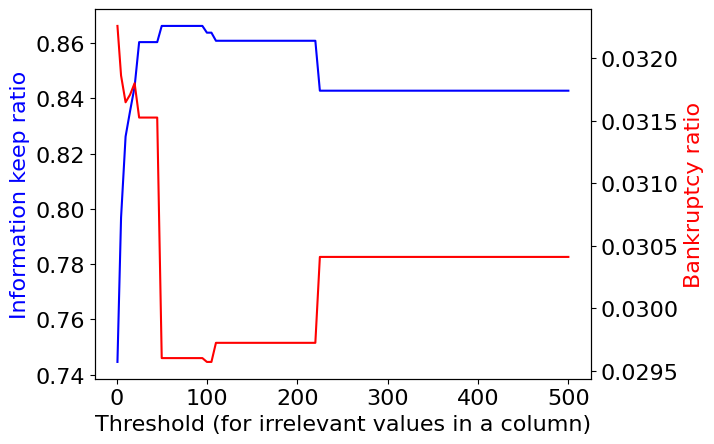

In [300]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.data_keep_ratio, color='blue')
ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.bankruptcy_ratio, color='red')

ax1.set_xlabel('Threshold (for irrelevant values in a column)')
ax1.set_ylabel('Information keep ratio', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')

##### Add `information kept x bankruptcy ratio` coefficient

In [301]:
df_tresholds_zoomed.loc[:,'ik_br_coeff'] = df_tresholds_zoomed['data_keep_ratio'] * df_tresholds_zoomed['bankruptcy_ratio']

/tmp/ipykernel_4717/3586746089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tresholds_zoomed.loc[:,'ik_br_coeff'] = df_tresholds_zoomed['data_keep_ratio'] * df_tresholds_zoomed['bankruptcy_ratio']


Text(0, 0.5, 'Bankruptcy ratio')

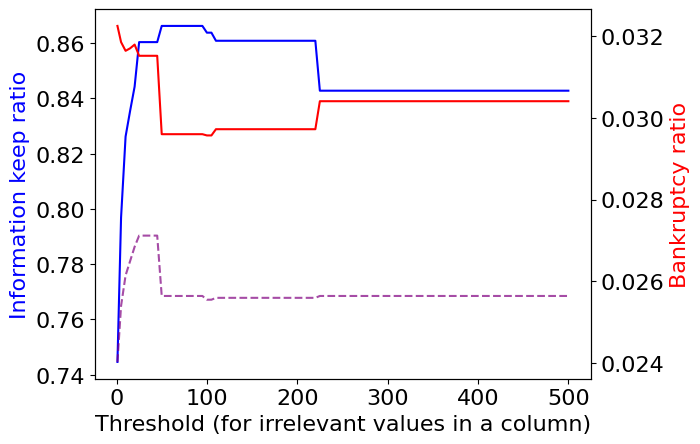

In [302]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.data_keep_ratio, color='blue')
ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.bankruptcy_ratio, color='red')
ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.ik_br_coeff, color='purple', linestyle='dashed', alpha=0.7)

ax1.set_xlabel('Threshold (for irrelevant values in a column)')
ax1.set_ylabel('Information keep ratio', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')

In [303]:
df_tresholds_zoomed[df_tresholds_zoomed.ik_br_coeff == df_tresholds_zoomed.ik_br_coeff.max()]

thresholds  data_keep_ratio  bankruptcy_ratio  ik_br_coeff
5        25.0         0.860352          0.031525     0.027115
6        30.0         0.860352          0.031525     0.027115
7        35.0         0.860352          0.031525     0.027115
8        40.0         0.860352          0.031525     0.027115
9        45.0         0.860352          0.031525     0.027115

In [304]:
opt_thresholds = df_tresholds_zoomed.thresholds[df_tresholds_zoomed.ik_br_coeff == df_tresholds_zoomed.ik_br_coeff.max()].values
opt_thresholds

array([25., 30., 35., 40., 45.], dtype=float16)

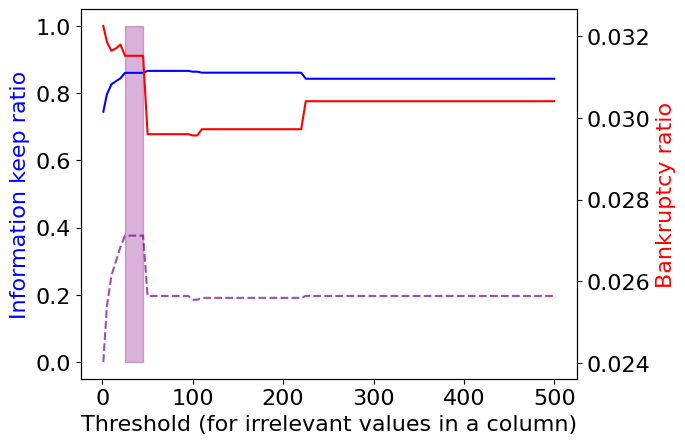

In [305]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.data_keep_ratio, color='blue')
ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.bankruptcy_ratio, color='red')
ax2.plot(df_tresholds_zoomed.thresholds, df_tresholds_zoomed.ik_br_coeff, color='purple', linestyle='dashed', alpha=0.7)

ax1.set_xlabel('Threshold (for irrelevant values in a column)')
ax1.set_ylabel('Information keep ratio', color='blue')
ax2.set_ylabel('Bankruptcy ratio', color='red')

ax1.fill_between(x=opt_thresholds, y1=0, y2=1, color='purple', alpha=0.3)

In [306]:
new_df = filter_dataset(df_X, label_col='bankrupt', t=opt_thresholds[0], return_df=True)

In [309]:
new_df

roa(c) before interest and depreciation before interest   
0                                              0.370594        \
1                                              0.464291         
2                                              0.426071         
3                                              0.399844         
4                                              0.465022         
...                                                 ...         
6814                                           0.493687         
6815                                           0.475162         
6816                                           0.472725         
6817                                           0.506264         
6818                                           0.493053         

      roa(a) before interest and % after tax   
0                                   0.424389  \
1                                   0.538214   
2                                   0.499019   
3                                   0.451265   
4                                   0.538432   
...                                      ...   
6814                                0.539468   
6815                                0.538269   
6816                                0.533744   
6817                                0.559911   
6818                                0.570105   

      roa(b) before interest and depreciation after tax   
0                                              0.405750  \
1                                              0.516730   
2                                              0.472295   
3                                              0.457733   
4                                              0.522298   
...                                                 ...   
6814                                           0.543230   
6815                                           0.524172   
6816                                           0.520638   
6817                                           0.554045   
6818                                           0.549548   

      operating gross margin  realized sales gross margin   
0                   0.601457                     0.601457  \
1                   0.610235                     0.610235   
2                   0.601450                     0.601364   
3                   0.583541                     0.583541   
4                   0.598783                     0.598783   
...                      ...                          ...   
6814                0.604455                     0.604462   
6815                0.598308                     0.598308   
6816                0.610444                     0.610213   
6817                0.607850                     0.607850   
6818                0.627409                     0.627409   

      operating profit rate  pre-tax net interest rate   
0                  0.998969                   0.796887  \
1                  0.998946                   0.797380   
2                  0.998857                   0.796403   
3                  0.998700                   0.796967   
4                  0.998973                   0.797366   
...                     ...                        ...   
6814               0.998992                   0.797409   
6815               0.998992                   0.797414   
6816               0.998984                   0.797401   
6817               0.999074                   0.797500   
6818               0.998080                   0.801987   

      after-tax net interest rate   
0                        0.808809  \
1                        0.809301   
2                        0.808388   
3                        0.808966   
4                        0.809304   
...                           ...   
6814                     0.809331   
6815                     0.809327   
6816                     0.809317   
6817                     0.809399   
6818                     0.813800   

      non-industry income and expenditure/revenue   
0          

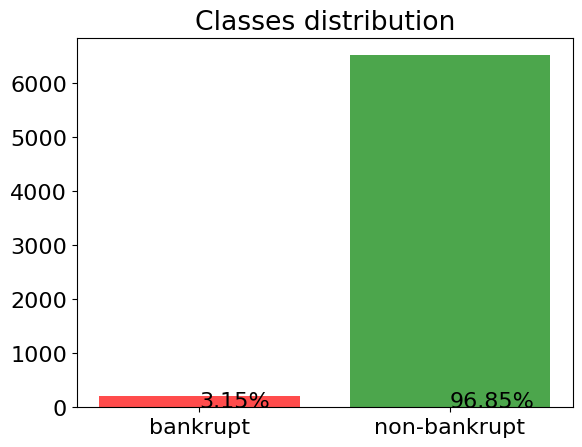

In [311]:
num_yes = len(new_df[new_df['bankrupt'] == 1])
num_no = len(new_df[new_df['bankrupt'] == 0])

plt.bar(['bankrupt', 'non-bankrupt'], [num_yes, num_no], color=['red', 'green'], alpha=0.7)
plt.title("Classes distribution")
add_value_label(['bankrupt', 'bon-bankrupt'], 
                [round(num_yes / (num_no + num_yes), 4), round(num_no / (num_no + num_yes), 4)])

### 1.4 Feature Correlations

We also suppose that some attributes are higly correlated, like `Pre-tax interest rate` and `After-tax interest rate`. The second feature doesn't bring any knew knowledge on a problem, so it's better to remove it for minimizing the chance of paying more attention at "Interest rates" area.

The execution would look like that:
1. Find correlated subsets of attributes (subset may consist of more that 2 elements as well)
2. Leave only one out of all correlated attributes for particular subset.

But first let's visualize the features correlations by using heatmaps.

### 1.4.1 Heatmaps

In [312]:
features = list(new_df.columns)
features.remove('bankrupt')

<Axes: >

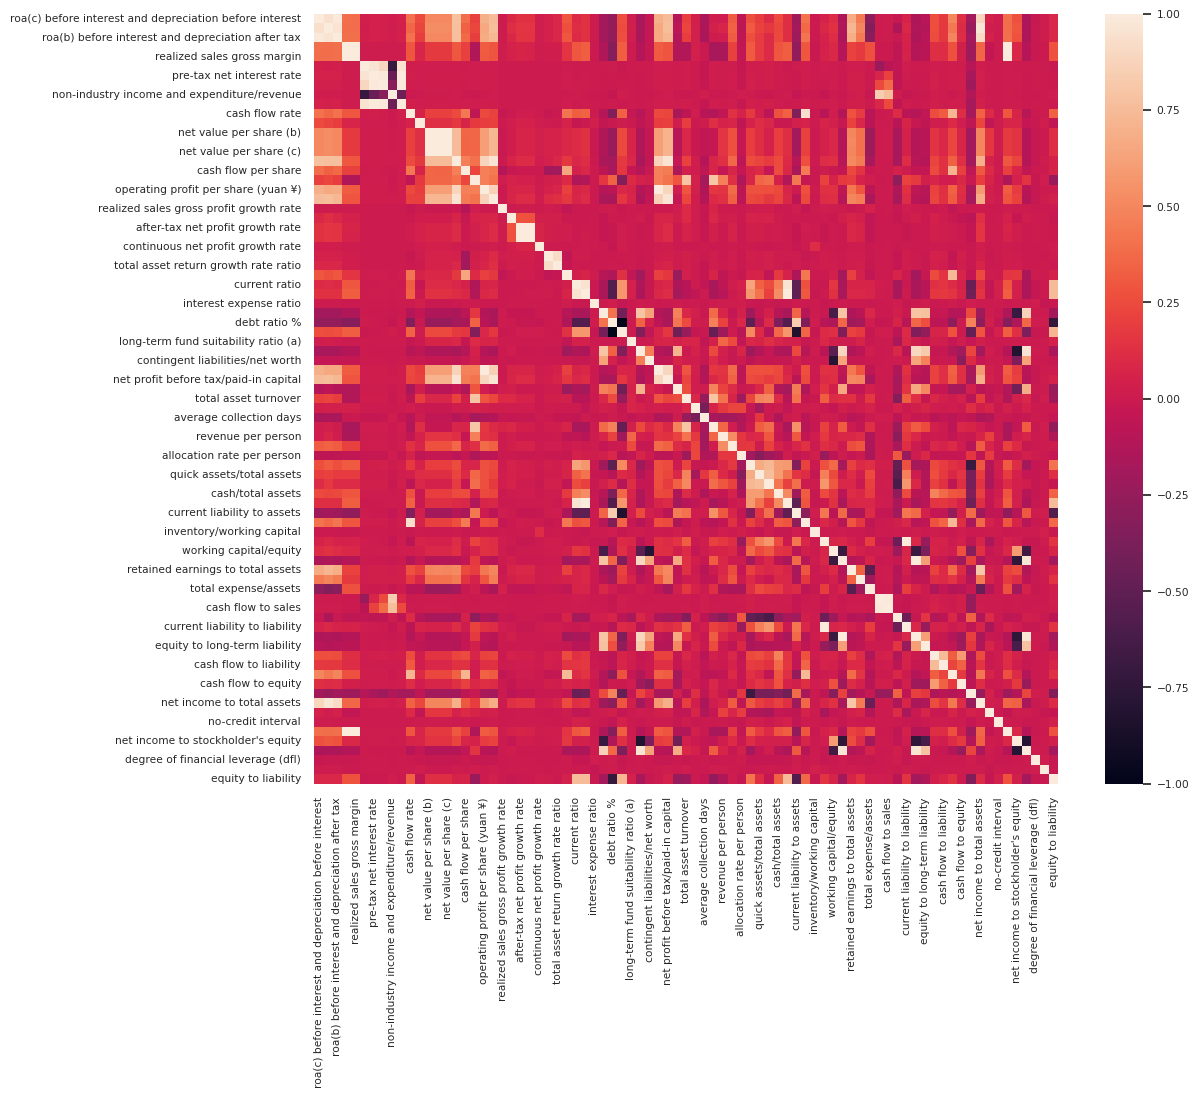

In [313]:
sn.set(font_scale=0.7)
df_X = new_df[features]
df_corr = df_X.corr()
f, axes = plt.subplots(1, figsize=(12,10))
sn.heatmap(df_corr)

A bit messy, isn't it?

Let's try to improve the readability by splitting the heatmap into smaller subcubes (10x10)

#### Heatmap Subcubes 

In [314]:
df_corr.shape

(81, 81)

In [315]:
# split column names into several lines for more readability
df_corr.columns = list(map(lambda colname: str_to_readable_title(colname, max_lines=3), df_corr.columns))
df_corr.index = df_corr.columns
df_corr = df_corr.apply(np.round, decimals=2)

In [316]:
cube_len = 10
cubes_per_line = 5

In [317]:
cubes = pd_to_cubes(df_corr, cube_len=cube_len)
n_cubes = len(cubes)

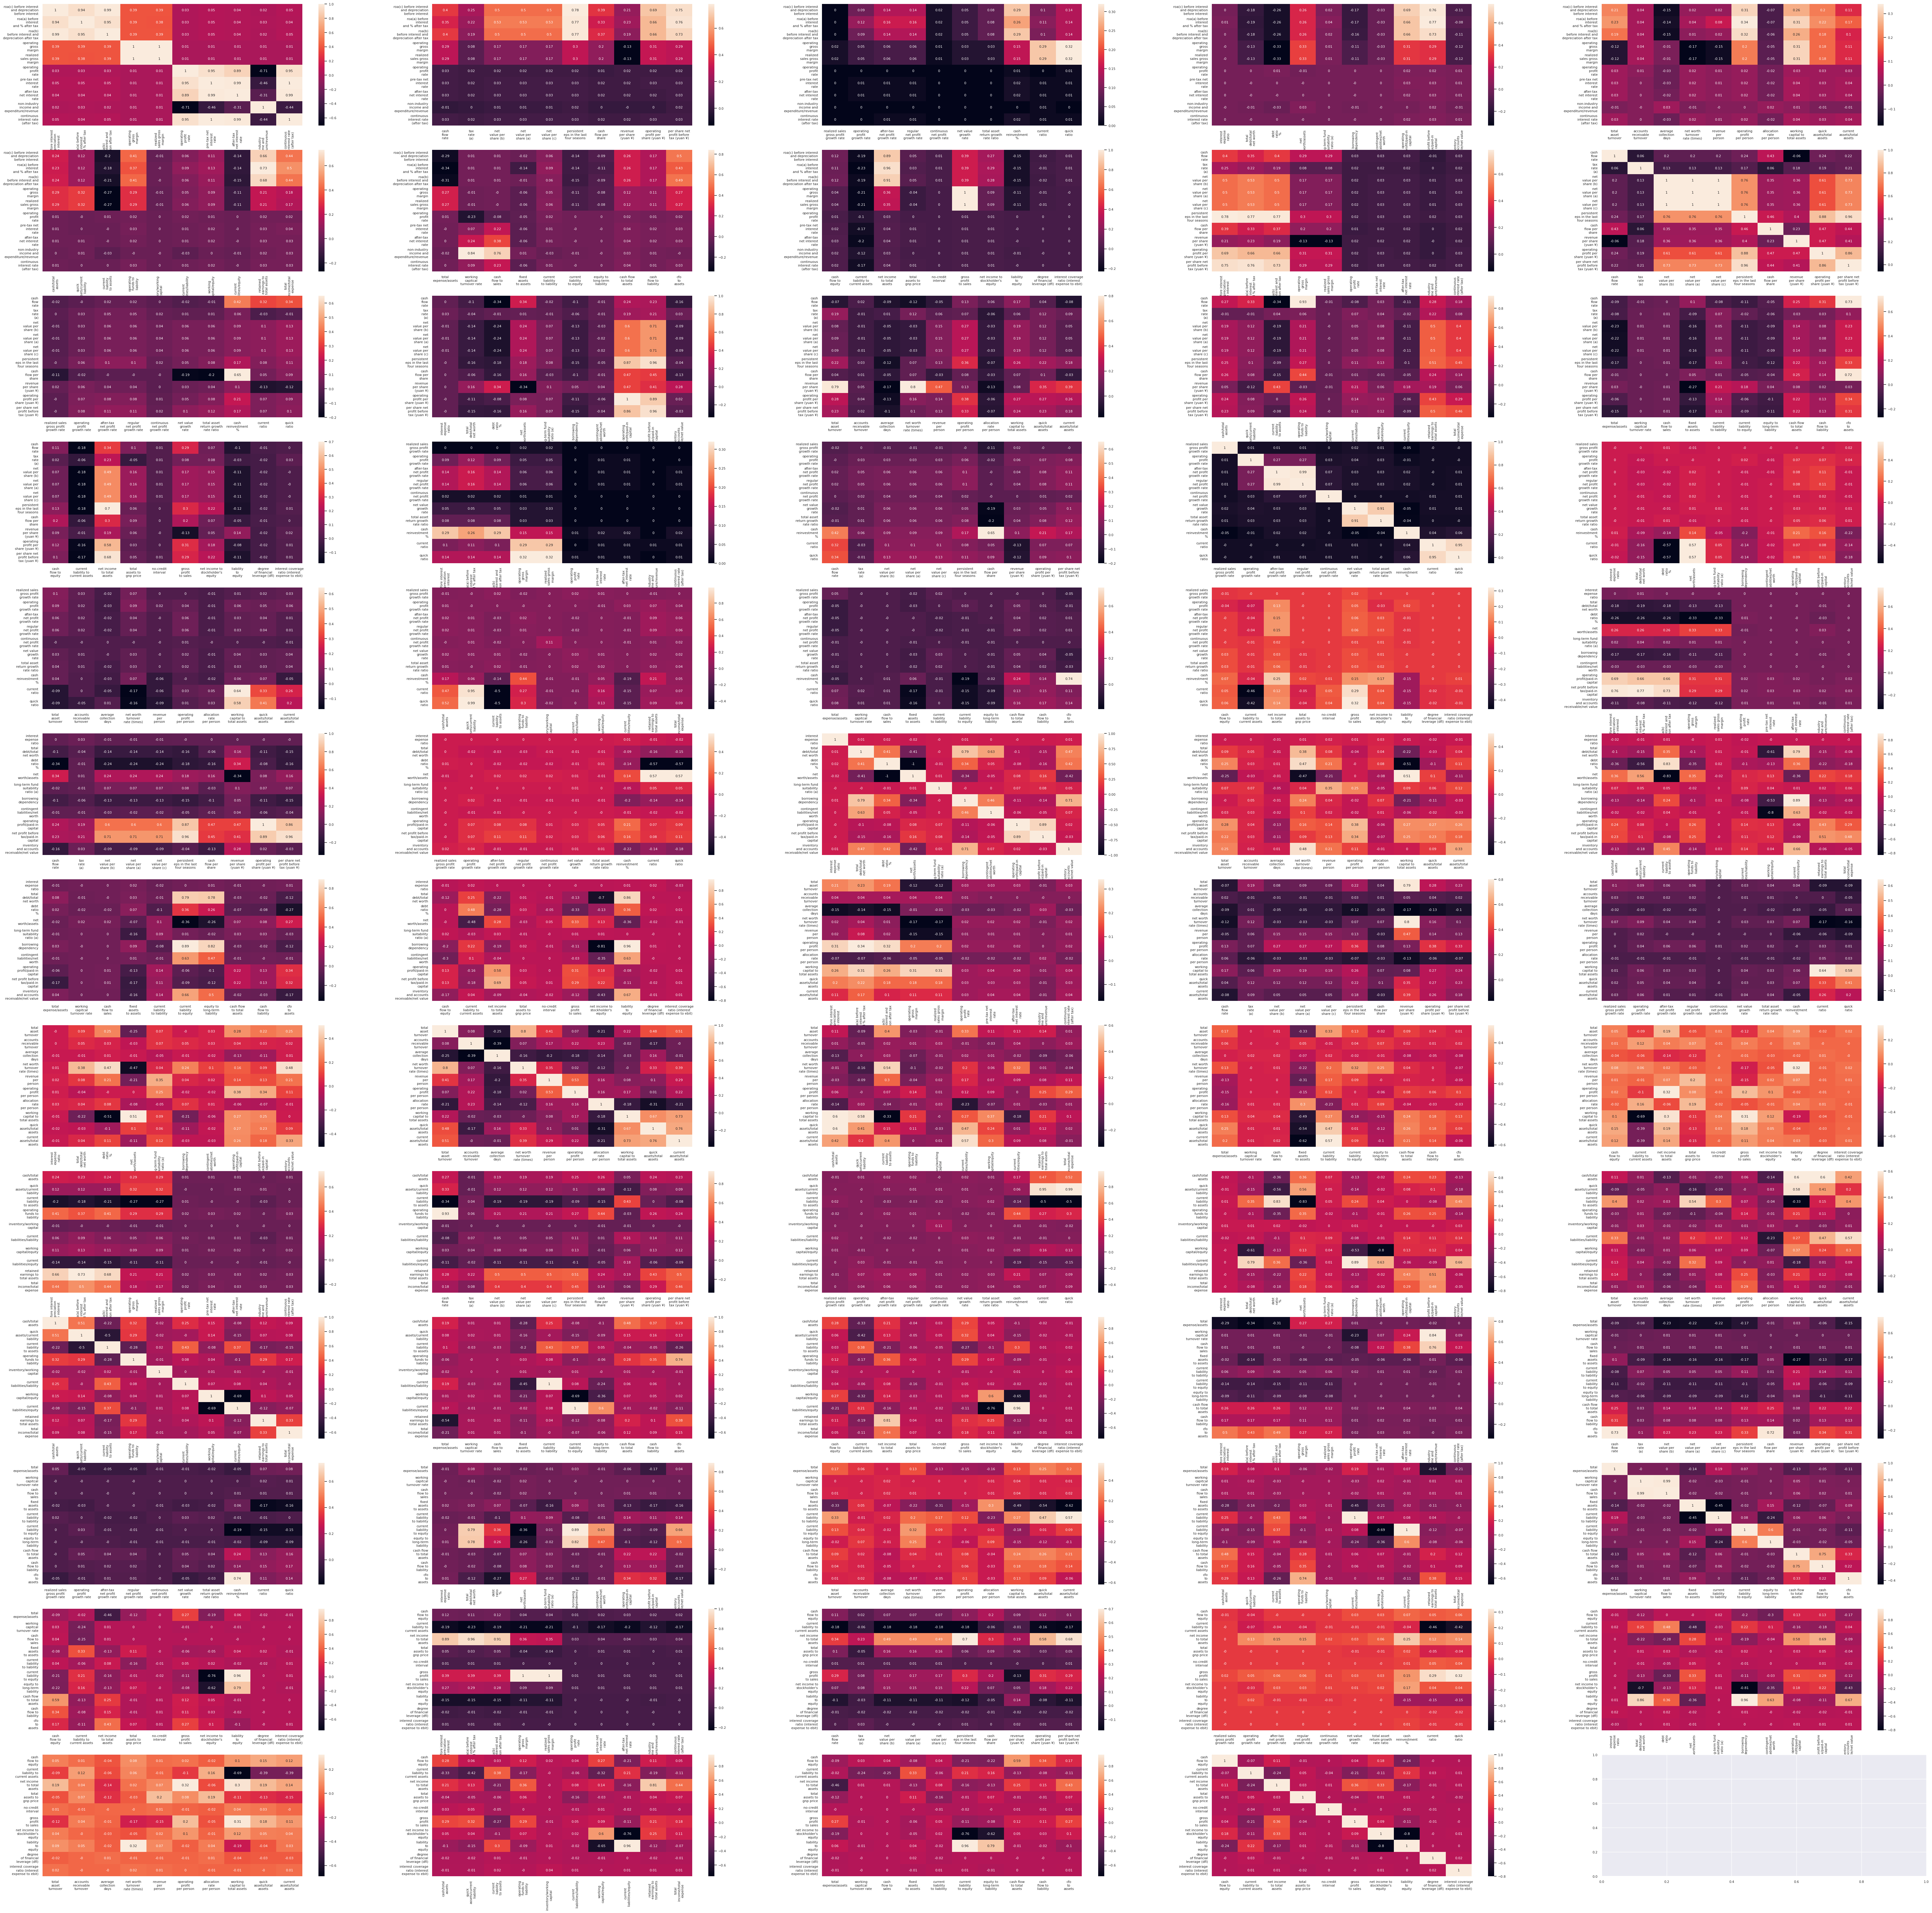

In [318]:
matplotlib.rcParams.update({'font.size': 8})

c, r = cubes_per_line, n_cubes // cubes_per_line + 1
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(80, 80))

for i, cube in enumerate(cubes):
    row_id, col_id = i // cubes_per_line, i % cubes_per_line
    sn.heatmap(cube, annot=True, ax=ax[row_id, col_id])

plt.show()

Now open corresponding .png file in images folder and zoom in.

In [53]:
# fig.savefig(os.path.join('images', 'correlation_heatmaps.png'))

---

### 1.4.2. Remove highly correlated features

First, let's define a threshold, that tells if two features are correlated to each other or not, as 0.9 

In [320]:
CORR_THRESHOLD = 0.9

##### Find correlated features

In [321]:
# all possible pairs of features
corr_pairs = list(permutations(df_corr.index, 2))

In [322]:
# left only correlated ones
corr_pairs = list(filter(lambda pair: abs(df_corr.loc[pair[0], pair[1]]) > CORR_THRESHOLD, corr_pairs))

In [323]:
# remove pair dublicates
corr_pairs = set(frozenset(tupl) for tupl in corr_pairs)
corr_pairs = [set(pair) for pair in corr_pairs]

In [324]:
corr_pairs

[{'debt\nratio\n%', 'net\nworth/assets'},
 {'gross\nprofit\nto sales', 'realized\nsales gross\nmargin'},
 {'net\nvalue per\nshare (a)', 'net\nvalue per\nshare (b)'},
 {'net profit before\ntax/paid-in\ncapital',
  'persistent\neps in the last\nfour seasons'},
 {'after-tax\nnet interest\nrate', 'continuous\ninterest rate\n(after tax)'},
 {'continuous\ninterest rate\n(after tax)', 'operating\nprofit\nrate'},
 {'net value\ngrowth\nrate', 'total asset\nreturn growth\nrate ratio'},
 {'roa(a) before\ninterest\nand % after tax',
  'roa(b)\nbefore interest and\ndepreciation after tax'},
 {'roa(a) before\ninterest\nand % after tax',
  'roa(c) before interest\nand depreciation\nbefore interest'},
 {'current\nratio', 'quick\nassets/current\nliability'},
 {'net\nvalue per\nshare (b)', 'net\nvalue per\nshare (c)'},
 {'after-tax\nnet interest\nrate', 'pre-tax net\ninterest\nrate'},
 {'net income\nto total\nassets',
  'roa(b)\nbefore interest and\ndepreciation after tax'},
 {'operating\nprofit per\nsh

We see that some attributes are repeated in different pairs. That's why we need to merge these correlated pairs into correlated sets. 

One way to do that is to write a few nested loops, but it's not fun. Let's do it a bit trickier - with recursion. Though it doesn't mean we will avoid nested loops at all :)

In [325]:
def merge_corr_pair_sets(list_of_sets):
    length = len(list_of_sets)
    l_copy = list_of_sets.copy()
    
    for i in range(length):
        for j in range(i+1, length):
            if list_of_sets[i].intersection(list_of_sets[j]):
                l_copy[i].update(l_copy[j])
                l_copy.remove(l_copy[j])
                return merge_corr_pair_sets(l_copy)
    return l_copy

In [326]:
corr_sets = merge_corr_pair_sets(corr_pairs)

In [327]:
corr_sets

[{'debt\nratio\n%', 'net\nworth/assets'},
 {'gross\nprofit\nto sales',
  'operating\ngross\nmargin',
  'realized\nsales gross\nmargin'},
 {'net\nvalue per\nshare (a)',
  'net\nvalue per\nshare (b)',
  'net\nvalue per\nshare (c)'},
 {'net profit before\ntax/paid-in\ncapital',
  'per share net\nprofit before\ntax (yuan ¥)',
  'persistent\neps in the last\nfour seasons'},
 {'after-tax\nnet interest\nrate',
  'continuous\ninterest rate\n(after tax)',
  'operating\nprofit\nrate',
  'pre-tax net\ninterest\nrate'},
 {'net value\ngrowth\nrate', 'total asset\nreturn growth\nrate ratio'},
 {'net income\nto total\nassets',
  'roa(a) before\ninterest\nand % after tax',
  'roa(b)\nbefore interest and\ndepreciation after tax',
  'roa(c) before interest\nand depreciation\nbefore interest'},
 {'current\nratio', 'quick\nassets/current\nliability', 'quick\nratio'},
 {'operating\nprofit per\nshare (yuan ¥)',
  'operating\nprofit/paid-in\ncapital'},
 {'cash\nflow to\nsales', 'working\ncapitcal\nturnover r

Results are just what we could expect:
* interest-rate based features landed up in one set
* profit-and-margin based features are in another set
* liability/equity features are in another set
* the same for net profit, value per share, ROA and so on

##### Remove correlated features

Note: for each set we leave only one feature in our dataset and remove the rest.

In [328]:
corr_lists = list(map(lambda cs: list(cs), corr_sets))

In [329]:
# The first attribute from each set will not be removed.
cols_to_remove = list(map(lambda l: l[1:], corr_lists))

In [330]:
# Merge all sublists af attributes into one list.
cols_to_remove = sum(cols_to_remove, [])

In [331]:
# Replace new lines with spaces
cols_to_remove = list(map(lambda col: re.sub('\n', ' ', col), cols_to_remove))

In [332]:
len(cols_to_remove)

24

In [347]:
df_final = new_df.drop(columns=cols_to_remove)
df_final

roa(c) before interest and depreciation before interest   
0                                              0.370594        \
1                                              0.464291         
2                                              0.426071         
3                                              0.399844         
4                                              0.465022         
...                                                 ...         
6814                                           0.493687         
6815                                           0.475162         
6816                                           0.472725         
6817                                           0.506264         
6818                                           0.493053         

      pre-tax net interest rate  non-industry income and expenditure/revenue   
0                      0.796887                                     0.302646  \
1                      0.797380                                     0.303556   
2                      0.796403                                     0.302035   
3                      0.796967                                     0.303350   
4                      0.797366                                     0.303475   
...                         ...                                          ...   
6814                   0.797409                                     0.303510   
6815                   0.797414                                     0.303520   
6816                   0.797401                                     0.303512   
6817                   0.797500                                     0.303498   
6818                   0.801987                                     0.313415   

      tax rate (a)  net value per share (a)  cash flow per share   
0         0.000000                 0.147950             0.311664  \
1         0.000000                 0.182251             0.318137   
2         0.000000                 0.177911             0.307102   
3         0.000000                 0.154187             0.321674   
4         0.000000                 0.167502             0.319162   
...            ...                      ...                  ...   
6814      0.113372                 0.175045             0.320966   
6815      0.371596                 0.181324             0.318278   
6816      0.490839                 0.269521             0.324857   
6817      0.181294                 0.213392             0.346573   
6818      0.000000                 0.220766             0.305793   

      revenue per share (yuan ¥)  operating profit per share (yuan ¥)   
0                       0.017560                             0.095921  \
1                       0.021144                             0.093722   
2                       0.005944                             0.092338   
3                       0.014368                             0.077762   
4                       0.029690                             0.096898   
...                          ...                                  ...   
6814                    0.020766                             0.098200   
6815                    0.023050                             0.098608   
6816                    0.044255                             0.100073   
6817                    0.031535                             0.111799   
6818                    0.000665                             0.092501   

      realized sales gross profit growth rate  operating profit growth rate   
0                                    0.022102                      0.848195  \
1                                    0.022080                      0.848088   
2                                    0.022760                      0.848094   
3                                    0.022046                      0.848005   
4                                    0.022096                      0.848258   
...                                       ...                           ...   
6814             

Let's check the heatmap once again. Now it has bright cells only on diagonal (feature correlation with itself = 1) and the rest of heatmap is darker, where the darkest cells are still far away from -1.

<Axes: >

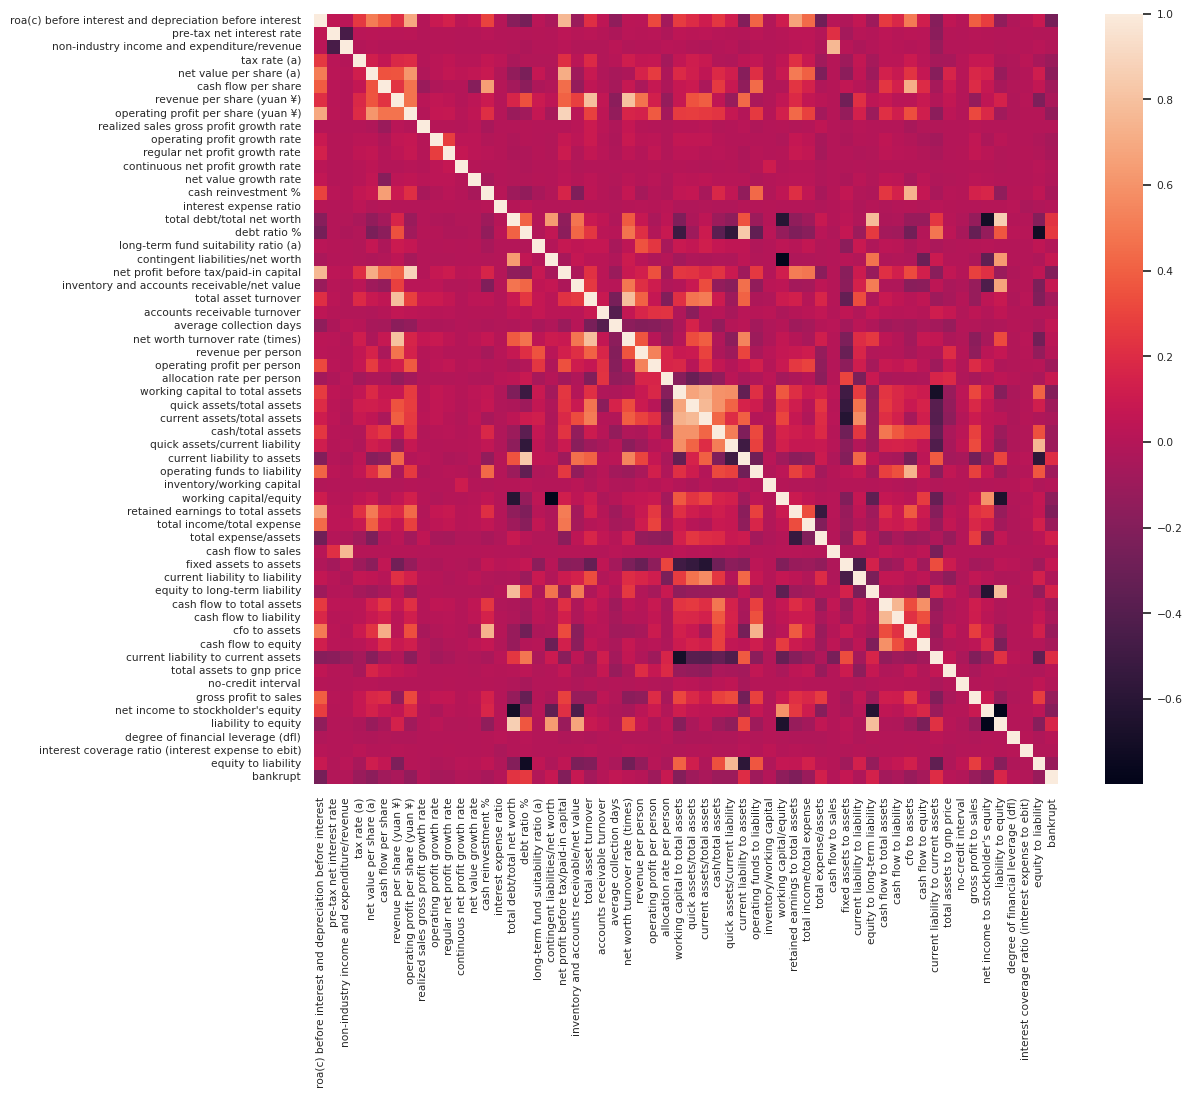

In [335]:
df_corr2 = df_final.corr()
f, axes = plt.subplots(1, figsize=(12,10))
sn.heatmap(df_corr2)

# 2. Balance data with oversampling

There are a few approaches for dealing with imbalanced data: 
* Random oversampling / undersampling
* SMOTE - based on KNN, while knn is probably not an appropriate algorithm for that data as datapoints from different classes are not linearly distinguishable
* ROSE
* Cost-Sensitive (or Class-Weighted) training
* Focal loss (only Deep Learning) - dynamically scales loss function; reduces cost values for easy examples and pays more attention on harder ones
* In-batch data sampling for Deep Learning - rare class instances will be more likely pick into batch and seen by neural network
* Custom Sampler - e.g. to ensure that batch has roughly the equal number of examples in each class.

Source: https://medium.com/cuenex/imbalanced-learning-in-fraud-prevention-42c60c01db3b

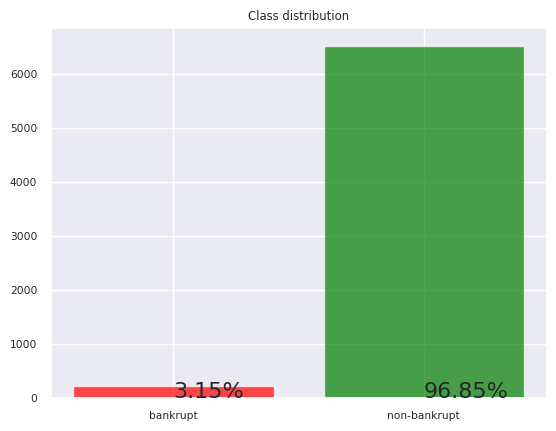

In [336]:
num_yes = len(clean_data[df_final['bankrupt'] == 1])
num_no = len(clean_data[df_final['bankrupt'] == 0])

plt.bar(['bankrupt', 'non-bankrupt'], [num_yes, num_no], color=['red', 'green'], alpha=0.7)
plt.title("Class distribution")
add_value_label(['bankrupt', 'non-bankrupt'], 
                [round(num_yes / (num_no + num_yes), 4), round(num_no / (num_no + num_yes), 4)])

### ROSE and SMOTE

ROSE and SMOTE are oversampling techniques, which generate more instances for lower numbered class. Unlike Random Oversampling, ROSE and SMOTE don't produce any duplicates of an instance, but a completely new datapoint in n-dimensional space, which is sufficiently close to other datapoints of minority class.

That's why it's important to use ROSE and SMOTE only for generating the training data. We don't want thr test set to contain any artificial instances. 

Below is the schema for this approach.

![train-test-split](train_test_split.png)

In [337]:
X = df_final.iloc[:,:-1].to_numpy()
Y = df_final.iloc[:,-1].to_numpy().reshape(df_final.shape[0])

### 2.1. Split data

In [339]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
tr = np.unique(Y_train, return_counts=True)[1]
tst = np.unique(Y_test, return_counts=True)[1]
print(f"\tTrain set\n\nbankrupt instances: {tr[1]},\nnon-bankrupt instances: {tr[0]}\n")
print(f"\tTest set\n\nbankrupt instances: {tst[1]},\nnon-bankrupt instances: {tst[0]}")

	Train set

bankrupt instances: 149,
non-bankrupt instances: 4559

	Test set

bankrupt instances: 63,
non-bankrupt instances: 1956


## 2.2. Oversampling

### 2.2.1. ROSE

In [340]:
rose = RandomOverSampler(random_state=31)
X_rose, Y_rose = rose.fit_resample(X_train, Y_train)
print(Counter(Y_rose))

Counter({0: 4559, 1: 4559})


### 2.2.2. SMOTE

In [341]:
sm = SMOTE(random_state=42)
X_sm, Y_sm = sm.fit_resample(X_train, Y_train)
print(Counter(Y_sm))

Counter({0: 4559, 1: 4559})


## 3. Train ML models

In this section we are going to test a few machine learning algorithms:
* SVM
* Tree-Based (RF, boosting methods like AdaBoost, lightGBM)
* Deep Neural Network

The crucial part of building machine learning model is to pick the right metric to evaluate its performance. But here is a challenge: the most popular and super intuitive metric for classification tasks, accuracy score, is not relaible when imbalanced data comes. That's why we need to consider alternative metrics that pay more attention on classes with fewer instatnces, such as:
* Weighted Balanced Accuracy
* Precision
* Recall
* F1 Score
* F-beta Score (beta < 1 if FP is more important than FN, beta > 1 otherwise)
* Probabilistic F Score
* AUC Curve

https://medium.com/cuenex/advanced-evaluation-metrics-for-imbalanced-classification-models-ee6f248c90ca

-------------

##### Class for unified representation of model's performance 

In [342]:
class Bankruptcy_Prediction_Model:
    def __init__(self, model, name, **hyperparameters):
        self.model = model
        self.name = name
        self.hyperparameters = hyperparameters
        
        self.weighted_balanced_accuracy = None
        self.precision_class_0 = None  # Non-bankrupts
        self.precision_class_1 = None  # Bankrupts
        
        self.recall_class_0 = None
        self.recall_class_1 = None
        
        self.f1_class_0 = None
        self.f1_class_1 = None
        
        self.f_beta = None
        self.AUC = None
        
    def evaluate(self, x, y):
        y_pred = self.model.predict(x)
        # y_proba = model.predict_proba(x)
        
        self.calculate_precision(y, y_pred)
        self.calculate_recall(y, y_pred)
        self.calculate_weighted_balanced_accuracy(y, y_pred)
        self.calculate_f_score(y, y_pred, beta=1)
        self.calculate_f_score(y, y_pred, beta=2) # False Negatives are more important, because we don't want to misclassify actual bankrupts
        # self.calculate_AUC(y_proba)
        
    def calculate_weighted_balanced_accuracy(self, true, predicted):
        self.weighted_balanced_accuracy = (self.recall_class_0 + self.recall_class_1) / 2
    
    def calculate_f_score(self, true, predicted, beta=1):
        if beta == 1:
            self.f1_class_0 = self.precision_class_0 * self.recall_class_0 / (self.precision_class_0 + self.recall_class_0)
            self.f1_class_1 = self.precision_class_1 * self.recall_class_1 / (self.precision_class_1 + self.recall_class_1)
        else:
            self.f_beta = (1 + beta**2) * self.precision_class_1 * self.recall_class_1 / (beta**2 * self.precision_class_1 + self.recall_class_1)
    
    def calculate_precision(self, true, predicted):
        self.precision_class_0 = (predicted == true)[true == 0].mean()
        self.precision_class_1 = (predicted == true)[true == 1].mean()
    
    def calculate_recall(self, true, predicted):
        self.recall_class_0 = (predicted == true)[predicted == 0].mean()
        self.recall_class_1 = (predicted == true)[predicted == 1].mean()
    
    def calculate_AUC(self, y_proba):
        pass
    
    def to_dict(self):
        d = {'Name': self.name}
        d.update(self.hyperparameters)
        d.update({'Weighted accuracy': self.weighted_balanced_accuracy,
               'Precision class 0': self.precision_class_0,
               'Precision class 1': self.precision_class_1,
               'Recall class 0': self.recall_class_0,
               'Recall class 1': self.recall_class_1,
               'F1 class 0': self.f1_class_0,
               'F1 class 1': self.f1_class_1,
               'F-Beta': self.f_beta})
        
        return d
    
    def to_list(self):
        return list(self.to_dict().values())

##### Multiprocessing

In [343]:
def worker(hyp_set, q):
    """Execute function. Then put the result on a queue."""

    res = func(hyp_set, return_str=True)
    res = ",".join(res)
    q.put(res)

    return res


def listener(q):
    """Listen for messages from a queue. Then write them to csv."""

    filename = re.sub('\W', '_', func.__doc__).lower() + '.csv'
    csv_path = os.path.join(MODELS_PATH,  filename)

    with open(csv_path, 'w', newline='\n', encoding='utf-8') as f:
        writer = csv.writer(f, delimiter=';')
        # Write header
        writer.writerow(hyperparameter_list + METRIC_DF_COLS)
        f.flush()

        while 1:
            m = q.get()
            if m == '<KILL>':
                print(f"Results have been writen into {filename}.")
                break

            writer.writerow(m.split(','))
            f.flush()

def handle_processes(hyperparameter_sets):

    manager = mp.Manager()
    q = manager.Queue()
    pool = mp.Pool(mp.cpu_count() + 2)

    # put listener to work first
    pool.apply_async(listener, (q,))

    # fire off workers
    jobs = []
    for hyp_set in hyperparameter_sets:
        job = pool.apply_async(worker, (hyp_set, q))
        jobs.append(job)

    # collect results from the workers through the pool result queue
    for job in tqdm(jobs):
        job.get()

    # now we are done, kill the listener
    q.put('<KILL>')
    pool.close()
    pool.join()

### 3.1. Random Forest

Hyperparameters

In [216]:
N_ESTIMATORS = np.arange(8, 65, 8)
MAX_DEPTHS = np.arange(8, 41, 8)
MIN_SAMPLES_SPLITS = np.power(2, np.arange(6, 1, -1)).astype(np.uint16)
MAX_FEATURES = np.arange(0.3, 1, 0.1)

In [217]:
N_ESTIMATORS

array([ 8, 16, 24, 32, 40, 48, 56, 64])

In [218]:
MAX_DEPTHS

array([ 8, 16, 24, 32, 40])

In [219]:
MIN_SAMPLES_SPLITS

array([64, 32, 16,  8,  4], dtype=uint16)

In [220]:
MAX_FEATURES

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [221]:
hyperparameters_sets = list(product(N_ESTIMATORS, MAX_DEPTHS, MIN_SAMPLES_SPLITS, MAX_FEATURES))
len(hyperparameters_sets)

1400

In [222]:
def test_one_rf_setup(setup, return_str=False):
    """Random Forest with different hyperparameters"""
    
    rf_cl = RandomForestClassifier(n_estimators=setup[0], 
                                   criterion='entropy', 
                                   max_depth=setup[1], 
                                   min_samples_split=setup[2],
                                   max_features=setup[3],
                                   random_state=35)
    rf_cl.fit(X_rose, Y_rose)
    bp_model = Bankruptcy_Prediction_Model(model=rf_cl, 
                                           name="Random Forest",
                                           n_estimators=rf_cl.n_estimators,
                                           max_depth=rf_cl.max_depth,
                                           min_samples_split=rf_cl.min_samples_split,
                                           max_features=rf_cl.max_features
                                          )
    bp_model.evaluate(X_test, Y_test)
    if return_str:
        return list(map(lambda x: str(x), bp_model.to_list()))
    return bp_model.to_list()

In [223]:
func = test_one_rf_setup
hyperparameter_list = ['Name', 'n_estimators', 'max_depth', 'min_samples_split', 'max_features']
handle_processes(hyperparameters_sets)

100%|███████████████████████████████████████| 1400/1400 [06:12<00:00,  3.76it/s]

Results have been writen into random_forest_with_different_hyperparameters.csv.


In [224]:
filename = re.sub('\W', '_', func.__doc__).lower() + '.csv'
csv_path = os.path.join(MODELS_PATH,  filename)
df_model_res = pd.read_csv(os.path.join(MODELS_PATH, filename), sep=";")

In [262]:
df_model_res.head()

Name  n_estimators  max_depth  min_samples_split  max_features   
0  Random Forest             8          8                 64           0.3  \
1  Random Forest             8          8                 32           0.3   
2  Random Forest             8          8                 32           0.4   
3  Random Forest             8          8                 64           0.4   
4  Random Forest             8          8                 64           0.5   

   Weighted accuracy  Precision class 0  Precision class 1  Recall class 0   
0           0.643469           0.956433           0.544118        0.983658  \
1           0.651769           0.958483           0.558824        0.984211   
2           0.691431           0.969759           0.573529        0.984904   
3           0.682035           0.963608           0.632353        0.986877   
4           0.675957           0.963608           0.602941        0.985842   

   Recall class 1  F1 class 0  F1 class 1    F-Beta  
0        0.303279    0.484927    0.194737  0.332734  
1        0.319328    0.485588    0.203209  0.349265  
2        0.397959    0.488636    0.234940  0.423913  
3        0.377193    0.487552    0.236264  0.410305  
4        0.366071    0.487299    0.227778  0.397287

#### Plot results in 3D
* hyperparameters are independent variables
* any evaluation metric (e.g. F1 for bankrupt class) is dependent variable

In current approach while training Random Forrests we are adjusting 4 hyperparameters (n_estimators, max_depth, min_samples_split, max_features). This gives us 4 dimensions of independent variables. However, we can apply only 2 of them at the same time on a single graph (F1-score is 3rd dimension).

One way to visualize these dependencies is to plot 6 graphs (2-element combinations of 4-element set). Below is an example:

In [233]:
fig = px.scatter_3d(df_model_res, x='n_estimators', y='max_depth', z='F1 class 1', color='F1 class 1',
                   title="N-estimators & Max-depth")
fig.show()

So while plotting results for just 2/4 hyperparameters we see a bit of redundancy (tall lines along F1 axis). This happens because for any particular set of 2 values (corresponding to chosen hyperparameters: `N estimators`, `Max depth`) there are two more dimensions (`Min samples split`, `Max features`), that we don't see, in which every set is unique.

To improve visual interpretations we replace scatter plot with surface plot, leaving only maximum F1 value for each set of (`N estimators`, `Max depth`).

In [239]:
combs = list(combinations(['n_estimators', 'max_depth', 'min_samples_split', 'max_features'], 2))
combs = list(map(lambda t: list(t) + ['F1 class 1'], combs))

In [240]:
combs

[['n_estimators', 'max_depth', 'F1 class 1'],
 ['n_estimators', 'min_samples_split', 'F1 class 1'],
 ['n_estimators', 'max_features', 'F1 class 1'],
 ['max_depth', 'min_samples_split', 'F1 class 1'],
 ['max_depth', 'max_features', 'F1 class 1'],
 ['min_samples_split', 'max_features', 'F1 class 1']]

In [269]:
pivots = dict()
for comb in combs:
    hyperpars = comb[:-1]
    metric = comb[-1]
    df_metric_set = df_model_res[comb].groupby(by=hyperpars).max(metric).reset_index()
    pivot_metric_set = df_metric_set.pivot(index=hyperpars[0], columns=hyperpars[1], values=metric)
    pivots[" & ".join(hyperpars)] = pivot_metric_set

In [273]:
hyp_combs = list(pivots.keys())

In [322]:
fig = make_subplots(rows=3, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}],
                          [{'is_3d': True}, {'is_3d': True}],
                          [{'is_3d': True}, {'is_3d': True}]],
                    subplot_titles=[" & ".join(c[:-1]) for c in combs],
                    horizontal_spacing=0.05,
                    vertical_spacing=0.05
                    )

ylocs = [0.15, 0.5, 0.85]
xlocs = [-0.2, 1.2]
for i, comb in enumerate(hyp_combs):
    fig.add_trace(go.Surface(z=pivots[comb], colorbar=dict(len=0.25, x=xlocs[i % 2], y=ylocs[i // 2])), i//2+1, i%2+1)
    
fig.update_layout(title_text="F1-score based on different hyperparameters setups",
                 height=1200, width=1200
                 )
fig.show()

In [333]:
fig.write_html(os.path.join('models', 'random-forest-hyperparameters-dependencies.html'))

---

### 2.3.2. SVM

In [160]:
kernel_functions = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [161]:
print("\t\tSVM FOR ROSE")
clf_rose = svm.SVC(kernel=kernel_functions[0]) # Linear Kernel
clf_rose.fit(X_rose, Y_rose)

y_pred = clf_rose.predict(X_test)

# Save metrics
f1['SVM ROSE'] = f1_score(Y_test, y_pred)
precision['SVM ROSE'] = precision_score(Y_test, y_pred)
recall['SVM ROSE'] = recall_score(Y_test, y_pred)

# Show confusion matrix and metrics
print(60 * "-" + "\nCONFUSION MATRIX:\n", confusion_matrix(Y_test, y_pred), '\n')
print(60 * "-" + "\nOTHER METRICS:\n", classification_report(Y_test, y_pred))

		SVM FOR ROSE
------------------------------------------------------------
CONFUSION MATRIX:
 [[1704  265]
 [  13   64]] 

------------------------------------------------------------
OTHER METRICS:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92      1969
           1       0.19      0.83      0.32        77

    accuracy                           0.86      2046
   macro avg       0.59      0.85      0.62      2046
weighted avg       0.96      0.86      0.90      2046



In [178]:
print("\t\tSVM FOR SMOTE")
clf_smote = svm.SVC(kernel=kernel_functions[0]) # Linear Kernel
clf_smote.fit(X_sm, Y_sm)

y_pred = clf_smote.predict(X_test)

# Save metrics
f1['SVM SMOTE'] = f1_score(Y_test, y_pred)
precision['SVM SMOTE'] = precision_score(Y_test, y_pred)
recall['SVM SMOTE'] = recall_score(Y_test, y_pred)

# Show confusion matrix and metrics
print(60 * "-" + "\nCONFUSION MATRIX:\n", confusion_matrix(Y_test, y_pred), '\n')
print(60 * "-" + "\nOTHER METRICS:\n", classification_report(Y_test, y_pred))

		SVM FOR SMOTE
------------------------------------------------------------
CONFUSION MATRIX:
 [[1696  273]
 [  12   65]] 

------------------------------------------------------------
OTHER METRICS:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1969
           1       0.19      0.84      0.31        77

    accuracy                           0.86      2046
   macro avg       0.59      0.85      0.62      2046
weighted avg       0.96      0.86      0.90      2046



### Neural Network

In [163]:
import tensorflow as tf
from keras import backend as K
from tensorflow.keras import regularizers

In [164]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [165]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001)
    
# model
model_rose = tf.keras.Sequential()
model_rose.add(tf.keras.layers.Dense(16, input_shape=(50,), activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_rose.add(tf.keras.layers.Dropout(0.2))

model_rose.add(tf.keras.layers.Dense(32, activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_rose.add(tf.keras.layers.Dropout(0.4))

model_rose.add(tf.keras.layers.Dense(32, activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_rose.add(tf.keras.layers.Dropout(0.4))

model_rose.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_rose.summary()

model_rose.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])

history_rose = model_rose.fit(X_rose, Y_rose, 
                    validation_data=(X_test, Y_test),
                    batch_size=128,
                    epochs=100)


print("\n\n\t\tNeural Network for ROSE")

y_pred = model_rose.predict(X_test)
y_pred = y_pred.round().astype('int64')

# Save metrics
f1['Neural Network ROSE'] = f1_score(Y_test, y_pred)
precision['Neural Network ROSE'] = precision_score(Y_test, y_pred)
recall['Neural Network ROSE'] = recall_score(Y_test, y_pred)

# Show confusion matrix and metrics
print(60 * "-" + "\nCONFUSION MATRIX:\n", confusion_matrix(Y_test, y_pred), '\n')
print(60 * "-" + "\nOTHER METRICS:\n", classification_report(Y_test, y_pred))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                

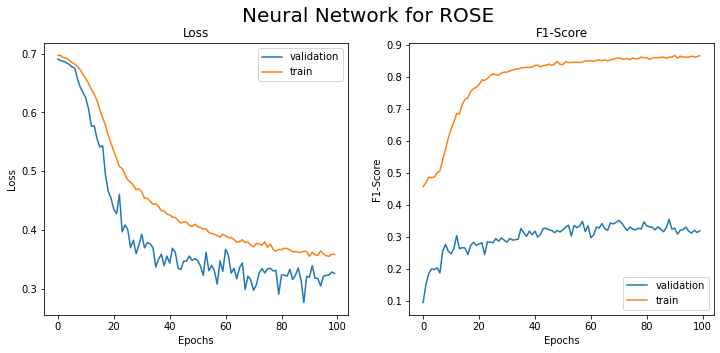

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(history_rose.history['val_loss'])
ax[0].plot(history_rose.history['loss'])
ax[0].legend(['validation', 'train'])
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(history_rose.history['val_f1_m'])
ax[1].plot(history_rose.history['f1_m'])
ax[1].legend(['validation', 'train'])
ax[1].set_title("F1-Score")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("F1-Score")

fig.suptitle('Neural Network for ROSE', fontsize=20)
plt.show()

In [167]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001)
    
# model
model_smote = tf.keras.Sequential()
model_smote.add(tf.keras.layers.Dense(16, input_shape=(50,), activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_smote.add(tf.keras.layers.Dropout(0.2))

model_smote.add(tf.keras.layers.Dense(32, activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_smote.add(tf.keras.layers.Dropout(0.4))

model_smote.add(tf.keras.layers.Dense(32, activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_smote.add(tf.keras.layers.Dropout(0.4))

model_smote.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_smote.summary()

model_smote.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])

history_smote = model_smote.fit(X_rose, Y_rose, 
                    validation_data=(X_test, Y_test),
                    batch_size=128,
                    epochs=100)


print("\n\n\t\tNeural Network for SMOTE")

y_pred = model_smote.predict(X_test)
y_pred = y_pred.round().astype('int64')

# Save metrics
f1['Neural Network SMOTE'] = f1_score(Y_test, y_pred)
precision['Neural Network SMOTE'] = precision_score(Y_test, y_pred)
recall['Neural Network SMOTE'] = recall_score(Y_test, y_pred)

# Show confusion matrix and metrics
print(60 * "-" + "\nCONFUSION MATRIX:\n", confusion_matrix(Y_test, y_pred), '\n')
print(60 * "-" + "\nOTHER METRICS:\n", classification_report(Y_test, y_pred))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_27 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                

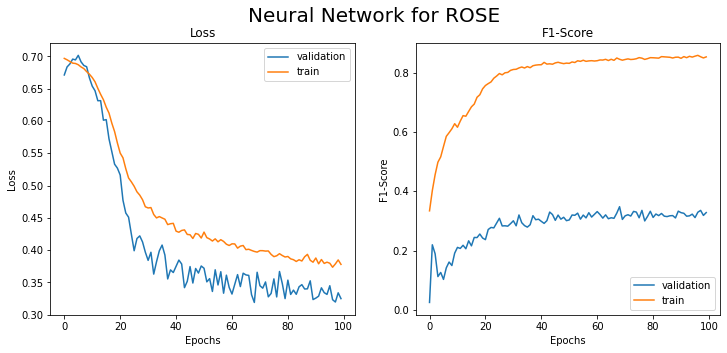

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(history_smote.history['val_loss'])
ax[0].plot(history_smote.history['loss'])
ax[0].legend(['validation', 'train'])
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(history_smote.history['val_f1_m'])
ax[1].plot(history_smote.history['f1_m'])
ax[1].legend(['validation', 'train'])
ax[1].set_title("F1-Score")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("F1-Score")

fig.suptitle('Neural Network for ROSE', fontsize=20)
plt.show()

# 3. Weights

Beside of oversampling techniques the defining of custom weights can be used as well. These weights are to be apply on a loss function depending on the predictive class.

In this case we don't need to generate any artificial data, so we are good stay with initial dataset.

In [169]:
cl_weights = {0: 1, 1: 10}

In this way we get the algorithm 10 times more penalty if it wrongly classified the lower-numbered-class instance.

### * Random Forest

In [170]:
print("\t\tRANDOM FOREST WITH CUSTOM WEIGHTS")

rf_weights = RandomForestClassifier(n_estimators=500, criterion='entropy', class_weight=cl_weights, max_depth=6, random_state=35)
rf_weights.fit(X_train, Y_train)

y_pred = rf_weights.predict(X_test)

# Save metrics
f1['Random Forest weights'] = f1_score(Y_test, y_pred)
precision['Random Forest weights'] = precision_score(Y_test, y_pred)
recall['Random Forest weights'] = recall_score(Y_test, y_pred)

# Show confusion matrix and metrics
print(60 * "-" + "\nCONFUSION MATRIX:\n", confusion_matrix(Y_test, y_pred), '\n')
print(60 * "-" + "\nOTHER METRICS:\n", classification_report(Y_test, y_pred))

		RANDOM FOREST WITH CUSTOM WEIGHTS
------------------------------------------------------------
CONFUSION MATRIX:
 [[1932   37]
 [  33   44]] 

------------------------------------------------------------
OTHER METRICS:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1969
           1       0.54      0.57      0.56        77

    accuracy                           0.97      2046
   macro avg       0.76      0.78      0.77      2046
weighted avg       0.97      0.97      0.97      2046



### * SVM

In [171]:
print("\t\tSVM FOR CUSTOM WEIGHTS")

cl_weights = {0: 1, 1: 6}
clf_weights = svm.SVC(kernel=kernel_functions[0], class_weight=cl_weights) # Linear Kernel
clf_weights.fit(X_train, Y_train)

y_pred = clf_weights.predict(X_test)

# Save metrics
f1['SVM weights'] = f1_score(Y_test, y_pred)
precision['SVM weights'] = precision_score(Y_test, y_pred)
recall['SVM weights'] = recall_score(Y_test, y_pred)

# Show confusion matrix and metrics
print(60 * "-" + "\nCONFUSION MATRIX:\n", confusion_matrix(Y_test, y_pred), '\n')
print(60 * "-" + "\nOTHER METRICS:\n", classification_report(Y_test, y_pred))

		SVM FOR CUSTOM WEIGHTS
------------------------------------------------------------
CONFUSION MATRIX:
 [[1923   46]
 [  41   36]] 

------------------------------------------------------------
OTHER METRICS:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1969
           1       0.44      0.47      0.45        77

    accuracy                           0.96      2046
   macro avg       0.71      0.72      0.72      2046
weighted avg       0.96      0.96      0.96      2046



### * Neural Network

In [172]:
cl_weights = {0: 1, 1: 20}

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=0.00001)
    
# model
model_weights = tf.keras.Sequential()
model_weights.add(tf.keras.layers.Dense(16, input_shape=(50,), activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_weights.add(tf.keras.layers.Dropout(0.2))

model_weights.add(tf.keras.layers.Dense(32, activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_weights.add(tf.keras.layers.Dropout(0.4))

model_weights.add(tf.keras.layers.Dense(32, activity_regularizer=regularizers.L2(0.0001), activation='relu'))
model_weights.add(tf.keras.layers.Dropout(0.4))


model_weights.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_weights.summary()

model_weights.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])

history_weights = model_weights.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test),
                    batch_size=128,
                    epochs=250,
                    class_weight=cl_weights)


print("\n\n\t\tNeural Network for Custom Weights")

y_pred = model_weights.predict(X_test)
y_pred = y_pred.round().astype('int64')

# Save metrics
f1['Neural Network weights'] = f1_score(Y_test, y_pred)
precision['Neural Network weights'] = precision_score(Y_test, y_pred)
recall['Neural Network weights'] = recall_score(Y_test, y_pred)

# Show confusion matrix and metrics
print(60 * "-" + "\nCONFUSION MATRIX:\n", confusion_matrix(Y_test, y_pred), '\n')
print(60 * "-" + "\nOTHER METRICS:\n", classification_report(Y_test, y_pred))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 16)                816       
_________________________________________________________________
dropout_30 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)               

Epoch 52/250
38/38 [==============================] - 0s 2ms/step - loss: 0.9542 - f1_m: 0.1263 - val_loss: 0.4537 - val_f1_m: 0.2574
Epoch 53/250
38/38 [==============================] - 0s 2ms/step - loss: 0.9487 - f1_m: 0.1338 - val_loss: 0.4416 - val_f1_m: 0.2501
Epoch 54/250
38/38 [==============================] - 0s 2ms/step - loss: 0.9460 - f1_m: 0.1411 - val_loss: 0.4409 - val_f1_m: 0.2859
Epoch 55/250
38/38 [==============================] - 0s 2ms/step - loss: 0.9572 - f1_m: 0.1730 - val_loss: 0.4432 - val_f1_m: 0.3619
Epoch 56/250
38/38 [==============================] - 0s 2ms/step - loss: 0.9353 - f1_m: 0.1569 - val_loss: 0.4371 - val_f1_m: 0.3638
Epoch 57/250
38/38 [==============================] - 0s 3ms/step - loss: 0.9171 - f1_m: 0.2001 - val_loss: 0.4354 - val_f1_m: 0.3723
Epoch 58/250
38/38 [==============================] - 0s 2ms/step - loss: 0.9368 - f1_m: 0.1347 - val_loss: 0.4259 - val_f1_m: 0.3646
Epoch 59/250
38/38 [==============================] - 0s 2ms/s

38/38 [==============================] - 0s 2ms/step - loss: 0.7264 - f1_m: 0.2448 - val_loss: 0.3197 - val_f1_m: 0.3385
Epoch 114/250
38/38 [==============================] - 0s 2ms/step - loss: 0.7175 - f1_m: 0.2309 - val_loss: 0.3065 - val_f1_m: 0.3630
Epoch 115/250
38/38 [==============================] - 0s 2ms/step - loss: 0.7446 - f1_m: 0.2201 - val_loss: 0.3215 - val_f1_m: 0.3324
Epoch 116/250
38/38 [==============================] - 0s 2ms/step - loss: 0.7274 - f1_m: 0.2291 - val_loss: 0.3245 - val_f1_m: 0.3259
Epoch 117/250
38/38 [==============================] - 0s 2ms/step - loss: 0.7278 - f1_m: 0.2027 - val_loss: 0.3188 - val_f1_m: 0.3320
Epoch 118/250
38/38 [==============================] - 0s 2ms/step - loss: 0.7485 - f1_m: 0.2386 - val_loss: 0.3292 - val_f1_m: 0.3148
Epoch 119/250
38/38 [==============================] - 0s 2ms/step - loss: 0.7212 - f1_m: 0.2307 - val_loss: 0.2985 - val_f1_m: 0.3643
Epoch 120/250
38/38 [==============================] - 0s 2ms/step - 

Epoch 174/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6776 - f1_m: 0.2548 - val_loss: 0.2887 - val_f1_m: 0.3441
Epoch 175/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6562 - f1_m: 0.2452 - val_loss: 0.2957 - val_f1_m: 0.3324
Epoch 176/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6460 - f1_m: 0.2515 - val_loss: 0.3016 - val_f1_m: 0.3322
Epoch 177/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6570 - f1_m: 0.2422 - val_loss: 0.2869 - val_f1_m: 0.3435
Epoch 178/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6428 - f1_m: 0.2433 - val_loss: 0.2882 - val_f1_m: 0.3379
Epoch 179/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6324 - f1_m: 0.2626 - val_loss: 0.2955 - val_f1_m: 0.3271
Epoch 180/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6770 - f1_m: 0.2308 - val_loss: 0.2947 - val_f1_m: 0.3311
Epoch 181/250
38/38 [==============================] - 

Epoch 235/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6171 - f1_m: 0.2511 - val_loss: 0.2713 - val_f1_m: 0.3662
Epoch 236/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6440 - f1_m: 0.2490 - val_loss: 0.2866 - val_f1_m: 0.3562
Epoch 237/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6205 - f1_m: 0.2760 - val_loss: 0.2833 - val_f1_m: 0.3611
Epoch 238/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6240 - f1_m: 0.2549 - val_loss: 0.2788 - val_f1_m: 0.3657
Epoch 239/250
38/38 [==============================] - 0s 2ms/step - loss: 0.5968 - f1_m: 0.2680 - val_loss: 0.2692 - val_f1_m: 0.3713
Epoch 240/250
38/38 [==============================] - 0s 2ms/step - loss: 0.5948 - f1_m: 0.2477 - val_loss: 0.2914 - val_f1_m: 0.3487
Epoch 241/250
38/38 [==============================] - 0s 2ms/step - loss: 0.6583 - f1_m: 0.2468 - val_loss: 0.2854 - val_f1_m: 0.3566
Epoch 242/250
38/38 [==============================] - 

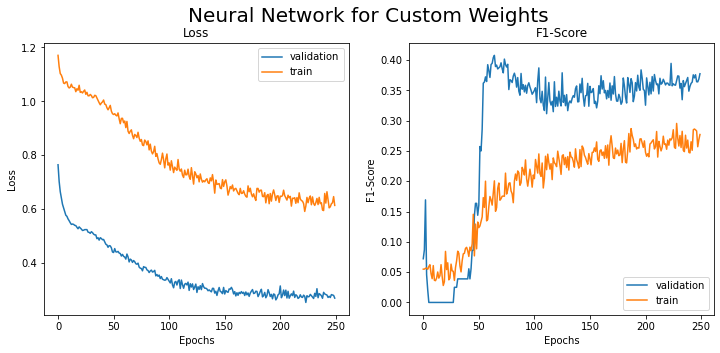

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(history_weights.history['val_loss'])
ax[0].plot(history_weights.history['loss'])
ax[0].legend(['validation', 'train'])
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(history_weights.history['val_f1_m'])
ax[1].plot(history_weights.history['f1_m'])
ax[1].legend(['validation', 'train'])
ax[1].set_title("F1-Score")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("F1-Score")

fig.suptitle('Neural Network for Custom Weights', fontsize=20)
plt.show()

# Compare Performance of Algorithms

In [179]:
f1_ = pd.DataFrame.from_dict(f1, orient='index', columns=['f1-score'])
precision_ = pd.DataFrame.from_dict(precision, orient='index', columns=['precision'])
recall_ = pd.DataFrame.from_dict(recall, orient='index', columns=['recall'])

In [180]:
metrics_df = pd.concat([f1_, precision_, recall_], axis=1).sort_values('f1-score')

In [181]:
metrics_df

f1-score  precision    recall
SVM SMOTE               0.313253   0.192308  0.844156
SVM ROSE                0.315271   0.194529  0.831169
Neural Network ROSE     0.316785   0.193642  0.870130
Neural Network SMOTE    0.329298   0.202381  0.883117
Random Forest SMOTE     0.375000   0.246914  0.779221
Neural Network weights  0.379822   0.246154  0.831169
SVM weights             0.452830   0.439024  0.467532
Random Forest ROSE      0.463320   0.329670  0.779221
Random Forest weights   0.556962   0.543210  0.571429

<AxesSubplot:>

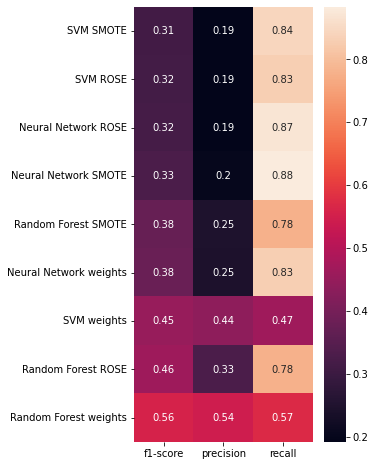

In [182]:
f, axes = plt.subplots(1, figsize=(4,8))
sn.heatmap(metrics_df, annot=True)

# Summary

1. The approach of defining weights for loss function is supposed to be most successful in terms of building classifiers for such kind of dataset (tabular and highly unbalanced).


2. Oversampling techniques (ROSE and SMOTE) are not doing well with SVM and Neral Network, whereas showing greater performace with Random Forest.


3. Random Forest certainly outperforms SVM and Neural Network for SMOTE, ROSE and weights.


4. Higher recall and lower precision for every setup suggests that algorithms face greater challenge with false predictions of bankruptcy rather than predict all the bankruptcy.